## Definição do *dataset*

O *dataset* utilizado será o "Electromyogram  (EMG)  Feature Reduction  Using Mutual ComponentsAnalysis for Multifunction  Prosthetic  Fingers Control" [1]. Maiores informações podem ser vistas no site: https://www.rami-khushaba.com/electromyogram-emg-repository.html

De acordo com a figura seguinte, neste *dataset* existem 15 movimentos de 8 pessoas diferentes. Algumas questões de projetos foram levadas em consideração:
1. Cada pessoa possui uma pasta com 45 arquivos .csv, cada arquivo refere-se à 1 movimento. Cada movimento possui 3 tentativas.
2. São 8 eletrodos no total e cada movimento possui 80.000 samples por eletrodo.

![15 movimentos](https://i.imgur.com/JpQrmRt.png)

[1] Rami N. Khushaba, Sarath Kodagoda, Dikai Liu, and Gamini Dissanayake "Electromyogram  (EMG)  Feature Reduction  Using Mutual ComponentsAnalysis for Multifunction  Prosthetic  Fingers Control". https://onedrive.live.com/?authkey=%21Ar1wo75HiU9RrLM&cid=AAA78954F15E6559&id=AAA78954F15E6559%21316&parId=AAA78954F15E6559%21312&o=OneUp



### Dependências

In [52]:
import numpy as np
from numpy import genfromtxt
import math
from librosa import stft
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

### Carregando dataset

Shape da matriz: 15 movimentos, 3 tentativas, 8 eletrodos, 80.000 samples

In [2]:
from glob import glob

# Obtendo lista dos arquivos
arquivos = list()
for num in range(1,9):
    s = "./Delsys_8Chans_15Classes/S{}-Delsys-15Class/*.csv".format(num)
    arquivos.append(glob(s))

# Ordenando por ordem alfabética
for i in range(8):
    arquivos[i].sort()

# Criando matriz do dataset
data = list()
for k in range(8):
    i = 0
    X1 = list()
    while(i < 45):
        listaTrial = list()
        for j in range(3):
            listaTrial.append(genfromtxt(arquivos[k][i], delimiter=',', unpack=True))
            i+=1
        X1.append(listaTrial)
    data.append(X1)
    
data = np.asarray(data)
print(data.shape)

(8, 15, 3, 8, 80000)


### Segmentação dos dados

In [3]:
data = data[:,:,:,:,0:20000]
print(data.shape)
# Definição do salto e do tamanho do segmento (segmento - salto = sobreposição)
salto = 470
segmento = 1024
n_win = int((data.shape[-1] - segmento) / salto) + 1
ids = np.arange(n_win) * salto
x = np.array([data[:,:,:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 3, 4, 0, 5)
print(x.shape)

(8, 15, 3, 8, 20000)
(8, 15, 3, 8, 41, 1024)


### Extraindo características no domínio do tempo

* `Mean Absolute Value (MAV)`: 
    > $\frac{1}{N}\sum_{i=1}^{N}|x_i|$

In [4]:
print(x.shape)
mav = np.sum(abs(x)/segmento, axis=-1)
print(mav.shape)

(8, 15, 3, 8, 41, 1024)
(8, 15, 3, 8, 41)


* `Variance of EMG (VAR)`: 
    > $\frac{1}{N-1}\sum_{i=1}^{N}x_i^2$

In [5]:
print(x.shape)
var = np.sum(np.power(x, 2)/(segmento-1), axis=-1)
print(var.shape)

(8, 15, 3, 8, 41, 1024)
(8, 15, 3, 8, 41)


* `Simple Square Integral (SSI)`: 
    > $\sum_{i=1}^{N}|x_i|^2$

In [6]:
print(x.shape)
ssi = np.sum(np.power(abs(x), 2), axis=-1)
print(ssi.shape)

(8, 15, 3, 8, 41, 1024)
(8, 15, 3, 8, 41)


* `Root Mean Square (RMS)`: 
    > $\sqrt{\frac{1}{N}\sum_{i=1}^{N}|x_i|^2}$

In [7]:
print(x.shape)
rms = np.sqrt(np.sum((np.power(abs(x), 2))/segmento, axis=-1))
print(rms.shape)

(8, 15, 3, 8, 41, 1024)
(8, 15, 3, 8, 41)


### Extraindo características no domínio da frequência

#### Transformação para o domínio da frequência

Aplicando stft no último eixo de data (3), com janela de 1024 e sobreposição de 512.

In [8]:
print(data.shape)
_, _, w = stft(data, fs=4000, nperseg=1024, noverlap=512)
w = np.swapaxes(w, 4, 5)
print(w.shape)

(8, 15, 3, 8, 20000)
(8, 15, 3, 8, 41, 513)


#### Power Spectrum Density (PSD)

Quadrado do valor absoluto de FFT.

In [9]:
psd = np.power(abs(w), 2)
print(psd.shape)

(8, 15, 3, 8, 41, 513)


* `Frequency Median (FMD)`: 
    > $\frac{1}{2}\sum_{i=1}^{M}PSD$

In [10]:
fmd = np.sum(psd/2, axis=-1)
print(fmd.shape)

(8, 15, 3, 8, 41)


* `Frequency Mean (FMN)`: 
    > $FMN = \frac{\sum_{i=1}^{M}f_i PSD}{\sum_{i=1}^{M}PSD_i}$
    
    > $f_i = \frac{i * SampleRate}{2M}$

In [11]:
sampleRate = 4000
M = 513
f = np.array([(i*sampleRate)/(2*M) for i in range(1,M+1)])

fmn = np.divide((np.sum(np.multiply(psd,f), axis = -1)), (np.sum(psd, axis=-1)))

print(fmn.shape)

(8, 15, 3, 8, 41)


#### Criando vetor de características 

In [26]:
X = list()
for i in range(8):
    features = list()
    for feature in (mav[i], var[i], ssi[i], rms[i], fmd[i], fmn[i]):
        feature = feature.transpose(0, 1, 3, 2)
        feature = feature.reshape(15 * 3 * 41, 8)
        features.append(feature)
    X.append(np.concatenate(features, axis=-1))

X = np.asarray(X)
print(X.shape)

(8, 1845, 48)


#### Criando vetor de labels

In [27]:
y = np.array([[str(i)] * int(X[0].shape[0] / 15) for i in range(15)])
y = y.reshape(y.shape[0] * y.shape[1])
y.shape

(1845,)

#### Classificação

Aplicando classificador SVC e testando acurácia para os diferentes valores de kernel, c e gamma.

Kernel: rbf , Gamma: 0.001 , C: 1
Acurácias:
Pessoa 1 : 66.79%
Pessoa 2 : 83.03%
Pessoa 3 : 77.08%
Pessoa 4 : 73.29%
Pessoa 5 : 87.55%
Pessoa 6 : 80.87%
Pessoa 7 : 72.02%
Pessoa 8 : 66.97%


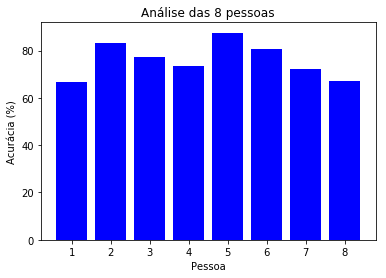

In [55]:
# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
C = 1
gamma = 0.001
kernel = 'rbf'
pessoas = list()
acuracias = list()
print('Kernel:', kernel, ', Gamma:', gamma, ', C:', C)
print('Acurácias:')
for i in range(8):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.3, shuffle=True)
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)
    res = clf.predict(X_test)
    tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
    pessoas.append(str(i+1))
    acuracias.append(tot_hit / X_test.shape[0] * 100)
    print('Pessoa', i+1, ': {:.2f}%'.format(acuracias[i]))

# Plotando grafico
plt.bar(pessoas, acuracias, color='blue')
plt.xticks(labels)
plt.ylabel('Acurácia (%)')
plt.xlabel('Pessoa')
plt.title('Análise das 8 pessoas')
plt.show()